#### 2. Анализ риск-факторов

##### Установка пакетов, загрузка и предобработка данных

In [89]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [103]:
import pandas as pd
import numpy as np
np.warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.tsa.stattools as stat
import statsmodels.graphics.tsaplots as spl
import statsmodels.graphics.gofplots
import statsmodels.tsa.seasonal as season

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller


import matplotlib as mpl
%matplotlib inline

Загрузим данные по риск-факторам. Для анализа будем использовать информацию о закрытии.

In [2]:
url_zero = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/zerobond.csv?token=ANGTEFTYY72T4L37HSJFT7K6LAG3E'
df_zero = pd.read_csv(url_zero, sep = ';')

In [33]:
url_rts = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/RTSI_160101_200101.csv?token=ANGTEFSOHJZLYH6333D63WC6LAHBQ'
df_rts = pd.read_csv(url_rts)
df_rts = df_rts.drop(['<TICKER>', '<PER>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<VOL>'], axis = 1)
rts = df_rts['<CLOSE>']
rts_date = df_rts['<DATE>']

In [37]:
url_moex = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/IMOEX_160101_200101.csv?token=ANGTEFRL66HHHUBN7CKLFOC6LAHFC'
df_moex = pd.read_csv(url_moex)
df_moex = df_moex.drop(['<TICKER>', '<PER>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<VOL>'], axis = 1)
moex = df_moex['<CLOSE>']
moex_date = df_moex['<DATE>']

In [38]:
url_usd = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/USD_RUB.csv?token=ANGTEFV2OHDJLVEU54IKCA26LAHOA'
df_usd = pd.read_csv(url_usd)
df_usd = df_usd.drop(['Open', 'High', 'Low', 'Change %'], axis = 1)
usd = df_usd['Price']
usd_date = df_usd['Date']

In [39]:
url_cyn = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/CNY_RUB.csv?token=ANGTEFUAX6XQWTH5DAA35XC6LAHSO'
df_cyn = pd.read_csv(url_cyn)
df_cyn = df_cyn.drop(['Open', 'High', 'Low', 'Change %'], axis = 1)
cyn = df_cyn['Price']
cyn_date = df_cyn['Date']

In [40]:
url_oil = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/ICE.BRN_160101_200101.csv?token=ANGTEFUEDHB4KGIJRVTWJEC6LAHWY'
df_oil = pd.read_csv(url_oil)
df_oil = df_oil.drop(['<TICKER>', '<PER>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<VOL>'], axis = 1)
oil = df_oil['<CLOSE>']
oil_date = df_oil['<DATE>']

Так как данные немного отличаются по временной структуре, то приведем их к одному виду.
Сначала будем проводить анализ на исходных данных.

In [58]:
rts_moex = pd.merge(df_rts, df_moex, on = '<DATE>', suffixes = ('RTS', 'MOEX'))

In [80]:
risk_factors = {'Date': df_rts['<DATE>'],
                'RTS': df_rts['<CLOSE>'],
                'MOEX': df_moex['<CLOSE>'],
                'USD': df_usd['Price'],
                'CYN': df_cyn['Price'],
                'OIL': df_oil['<CLOSE>']
                }

df_risk = pd.DataFrame(risk_factors, columns = ['Date', 'RTS', 'MOEX', 'USD', 'CYN', 'OIL'],  )


df_risk = df_risk.dropna()
df_risk = df_risk.reset_index(drop=True)

In [68]:
df_risk.describe()

,RTS,MOEX,USD,CYN,OIL
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,1123.221792,2244.819822,63.224164,9.430454,57.857277
std,165.712926,316.128123,4.627738,0.800129,12.273124
min,628.410000,1608.360000,55.713400,8.109400,27.790000
25%,1018.262500,1976.505000,59.296950,8.833600,49.160000
50%,1134.085000,2226.485000,63.756400,9.449600,55.715000
75%,1218.885000,2445.117500,65.630500,9.796450,67.282500
max,1549.400000,3050.470000,82.681300,12.605600,86.100000


Описательная статистика риск-факторов: 
- основные статистические характеристки;
- «тяжесть хвостов» распределений;
- тренд, сезонность, стационарность.


In [81]:
rts = df_risk['RTS']
moex = df_risk['MOEX']
usd = df_risk['USD']
cyn = df_risk['CYN']
oil = df_risk['OIL']

In [124]:
def desc_risk(y, figsize=(15, 10), style='bmh' ):
    with plt.style.context(style):    
        print(y.describe())
        
        print(mk.original_test(y))
        #If the pvalue is above a critical size, then we cannot reject that there is a unit root.
        
        #adf with constant
        adf_c = adfuller(y, regression = 'c')
        print('ADF Statistic const: %f' % adf_c[0])
        print('p-value: %f' % adf_c[1])
        
        #adf with constant and trend
        adf_ct = adfuller(y, regression = 'ct')
        print('ADF Statistic trend: %f' % adf_ct[0])
        print('p-value: %f' % adf_ct[1])
        
        #adf with no constant and no trend
        adf_nc = adfuller(y, regression = 'nc')
        print('ADF Statistic trend: %f' % adf_nc[0])
        print('p-value: %f' % adf_nc[1])
        
        
        fig = plt.figure(figsize=figsize)
        layout = (4, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        prob_ax = plt.subplot2grid(layout, (3, 0))
        hist_ax = plt.subplot2grid(layout, (3, 1))

        y.plot(figsize=(15, 10), ax = ts_ax)
        spl.plot_acf(y, lags = 30, ax = acf_ax)
        spl.plot_pacf(y, lags = 30, ax = pacf_ax)
        
        #normal distribution
        pp_n = statsmodels.graphics.gofplots.ProbPlot(y, fit=True)
        pp_n.qqplot(line ='r', ax = qq_ax); plt.title('Q-Q')
        pp_n.ppplot(line='45', ax = pp_ax); plt.title('P-P')
        pp_n.probplot(line='r', ax = prob_ax); plt.title('Prob')
        
        y.hist(bins = 30, ax = hist_ax); 
        plt.title('Histogram')
    return

count    1010.000000
mean     1123.221792
std       165.712926
min       628.410000
25%      1018.262500
50%      1134.085000
75%      1218.885000
max      1549.400000
Name: RTS, dtype: float64
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=33.15466368509415, Tau=0.6966999970561972, s=355000.0, var_s=114647610.0, slope=0.485357142857143)
ADF Statistic const: -1.203146
p-value: 0.672241
ADF Statistic trend: -2.733421
p-value: 0.222470
ADF Statistic trend: 1.438067
p-value: 0.962356


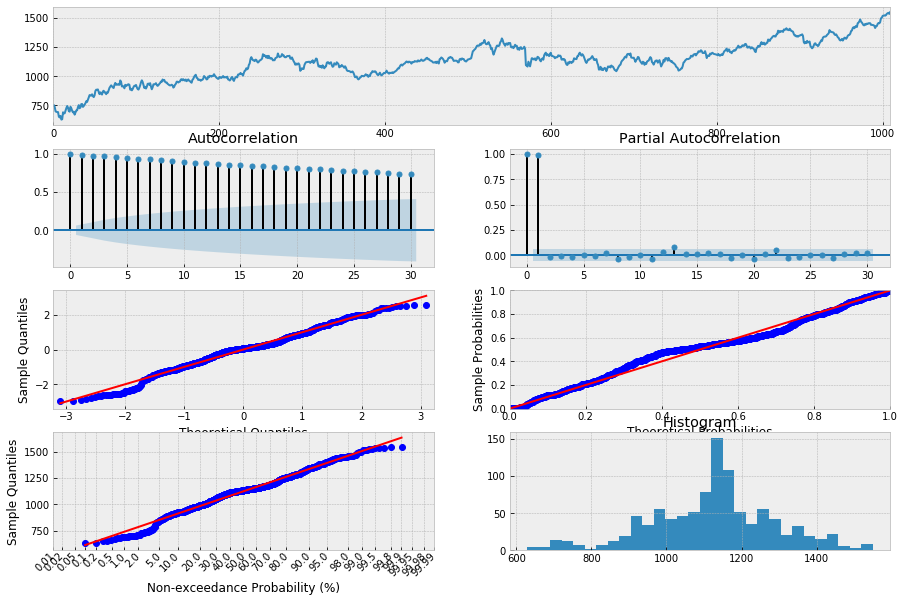

In [125]:
desc_risk(rts)

count    1010.000000
mean     2244.819822
std       316.128123
min      1608.360000
25%      1976.505000
50%      2226.485000
75%      2445.117500
max      3050.470000
Name: MOEX, dtype: float64
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=38.68991873731646, Tau=0.8130155334661315, s=414268.0, var_s=114647620.0, slope=1.010277777777777)
ADF Statistic const: -0.050190
p-value: 0.954179
ADF Statistic trend: -2.167179
p-value: 0.508335
ADF Statistic trend: 2.040594
p-value: 0.991305


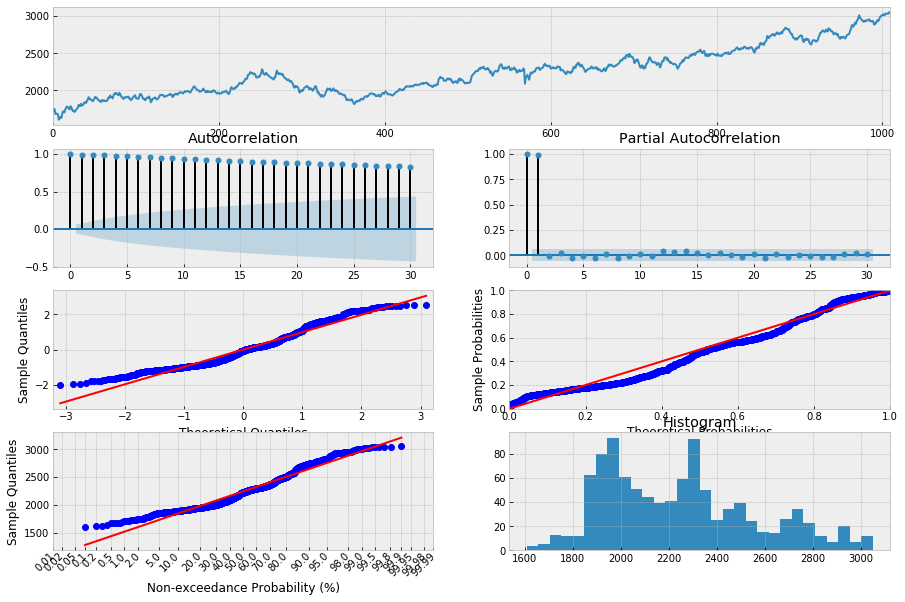

In [126]:
desc_risk(moex)

count    1010.000000
mean       63.224164
std         4.627738
min        55.713400
25%        59.296950
50%        63.756400
75%        65.630500
max        82.681300
Name: USD, dtype: float64
Mann_Kendall_Test(trend='no trend', h=False, p=0.9377667111859607, z=0.07807711501388777, Tau=0.0016426419648902452, s=837.0, var_s=114647619.0, slope=3.3623910336240376e-05)
ADF Statistic const: -2.429139
p-value: 0.133681
ADF Statistic trend: -2.371365
p-value: 0.394949
ADF Statistic trend: -0.858033
p-value: 0.346250


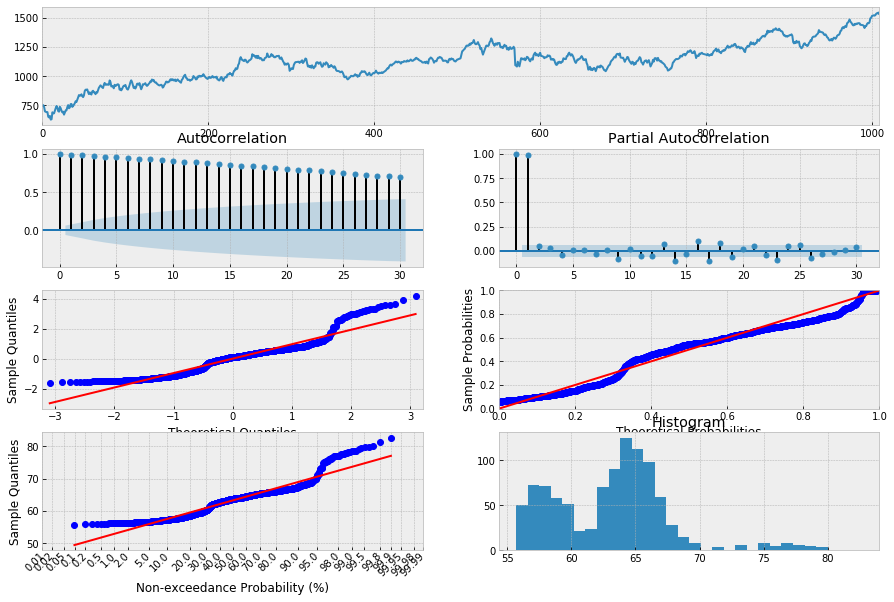

In [115]:
desc_risk(usd)

Text(0.5, 1.0, 'Prob')

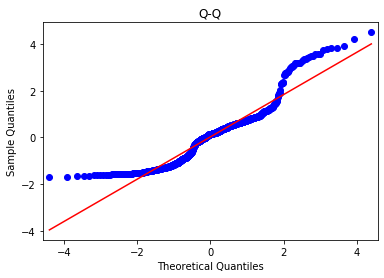

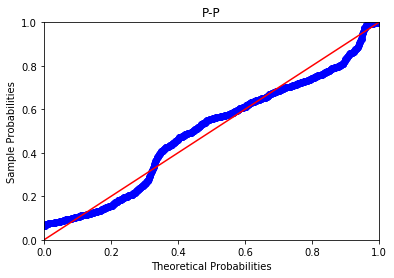

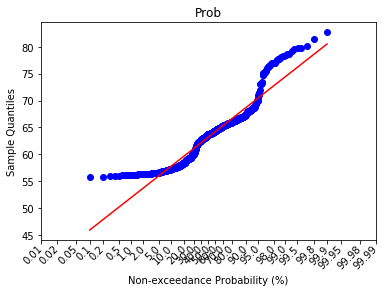

In [128]:
#student distir
y = usd        
pp_n = statsmodels.graphics.gofplots.ProbPlot(y, dist=scs.t, fit=True)
pp_n.qqplot(line ='r'); plt.title('Q-Q')
pp_n.ppplot(line='45'); plt.title('P-P')
pp_n.probplot(line='r'); plt.title('Prob')

count    1010.000000
mean        9.430454
std         0.800129
min         8.109400
25%         8.833600
50%         9.449600
75%         9.796450
max        12.605600
Name: CYN, dtype: float64
Mann_Kendall_Test(trend='no trend', h=False, p=0.19538570597805016, z=-1.2948102187290125, Tau=-0.027210550589251193, s=-13865.0, var_s=114647572.33333333, slope=-0.00011907131011608564)
ADF Statistic const: -3.023543
p-value: 0.032754
ADF Statistic trend: -2.610147
p-value: 0.275244
ADF Statistic trend: -1.280156
p-value: 0.184880


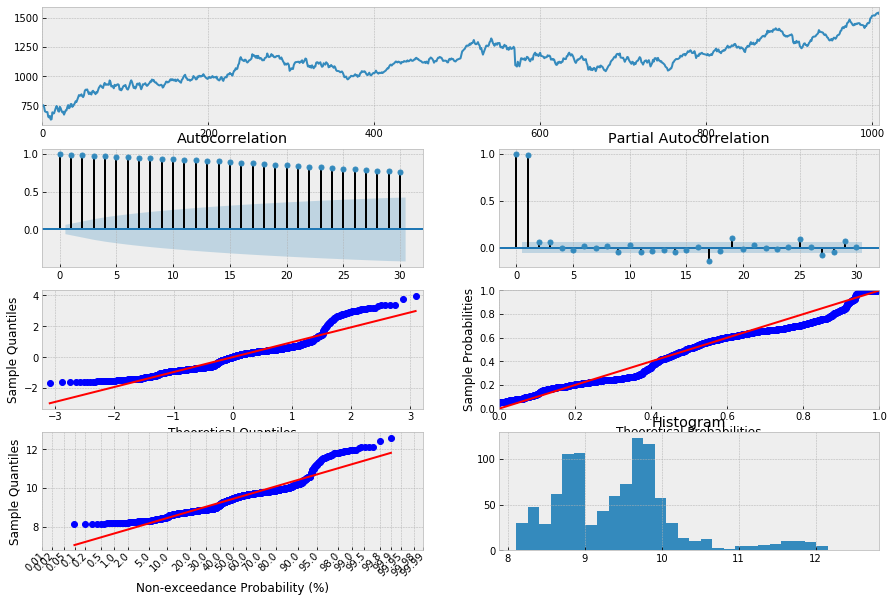

In [116]:
desc_risk(cyn)

Text(0.5, 1.0, 'Prob')

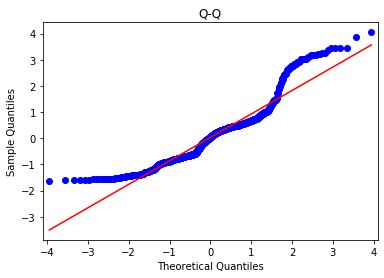

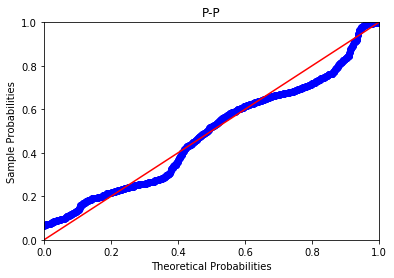

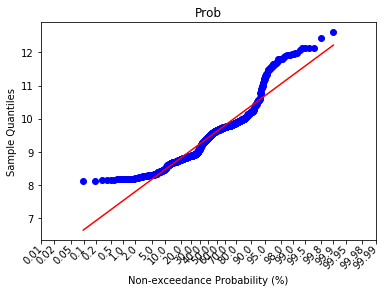

In [129]:
#student distir
y = cyn    
pp_n = statsmodels.graphics.gofplots.ProbPlot(y, dist=scs.t, fit=True)
pp_n.qqplot(line ='r'); plt.title('Q-Q')
pp_n.ppplot(line='45'); plt.title('P-P')
pp_n.probplot(line='r'); plt.title('Prob')

count    1010.000000
mean       57.857277
std        12.273124
min        27.790000
25%        49.160000
50%        55.715000
75%        67.282500
max        86.100000
Name: OIL, dtype: float64
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=31.804954099225608, Tau=0.6683374383027996, s=340548.0, var_s=114647495.33333333, slope=0.03854761904761904)
ADF Statistic const: -1.550592
p-value: 0.508352
ADF Statistic trend: -2.186537
p-value: 0.497431
ADF Statistic trend: 0.787581
p-value: 0.882835


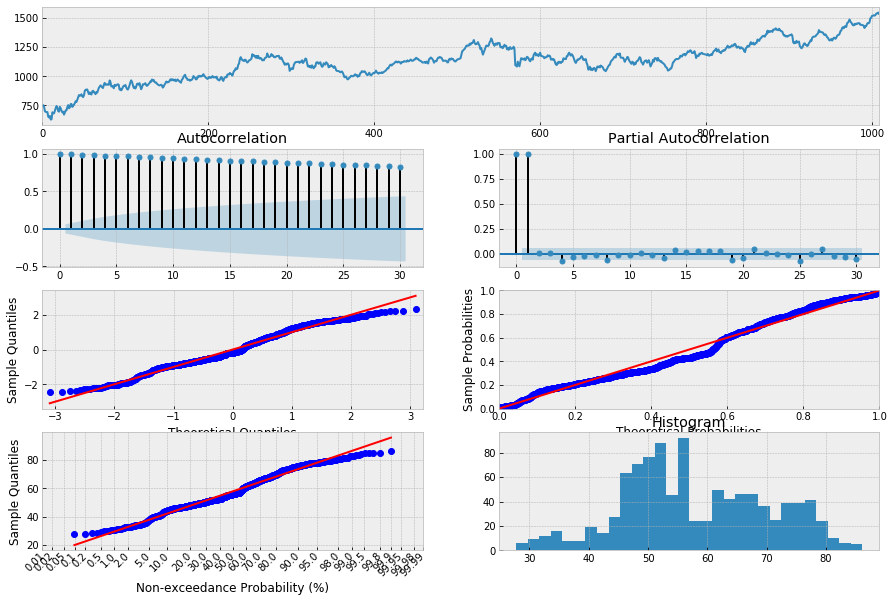

In [117]:
desc_risk(oil)

#### Основные вывод по описательной статистике: 
- индекс РТС в среднем имел значение на момент закрытия торгов в 1123 рубля. При этом в данных имеется восходящий тренд, при этом не является стационарным по тесту Дики-Фулера. Распределение не имеет тяжелых хвостов и похоже на нормальное.
- индекс МосБиржи на протяжении изучаемого периода имел в среднем цену закрытия в 2245 рублей. В данном ряде также имеется восходящий тренд, а сам ряд не является стационарным. В распределении выделяются левый и правый хвосты. Основное количество значений смещено к левому хвосту.
- значение курса доллара к рублю за период в среднем было равно 63 рубля за доллар. В данных не прослеживается тренд, но и ряд не является стационарным. Распределение не является нормальным или близким к нему. Не совпадает оно также и с распределением Стьюдента.
- значение курса юаня к рублю за период в среднем было равно 9.4 рубля за юань. Тест на тренд отклоняется, в данных нет тренда. При этом значения являются стационарными на уровне 5%. Само распределение имеет выделяющиеся хвосты и не похоже ни на нормальное, ни на Стьюдента. 
- значением нефти марки Брент за период было равно 57.8 рублям за баррель. В данных есть восходящий тренд. Тесты на стационарность отвергаются, ряд не стационарный. Распределение близко к нормальному, но имеет тяжелые хвосты. 

#### Взаимодействие факторов

In [131]:
df_risk.corr()

,RTS,MOEX,USD,CYN,OIL
RTS,1.000000,0.899913,-0.416864,-0.397177,0.667483
MOEX,0.899913,1.000000,0.002851,-0.064117,0.735441
USD,-0.416864,0.002851,1.000000,0.839728,-0.066666
CYN,-0.397177,-0.064117,0.839728,1.000000,-0.275312
OIL,0.667483,0.735441,-0.066666,-0.275312,1.000000


Как видим из матрицы парных корреляций, индексы РТС и ММВБ обладают прямой сильной связью. При этом оба индекса имеют умеренную связь с ценой на нефть марки Brent.

### For reference  (do not use)

In [146]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit_transform(X = [df_risk['RTS'],df_risk['MOEX'], df_risk['USD'], df_risk['CYN'], df_risk['OIL']] )
print(pca.explained_variance_ratio_)

[0.99893937 0.0010334 ]


PCA объединяет все данные в одну переменную.